In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import AutoMinorLocator
from tdse_solver import *

a = 10
b = 2*np.pi / a
nkpts = 120
nbnds = 5
k0 = np.linspace(-0.5, 0.5, nkpts, endpoint=True)

deep_red = '#C44E52'
dark_red = '#8B0000'
deep_blue = '#4C72B0'
deep_green = '#55A868'

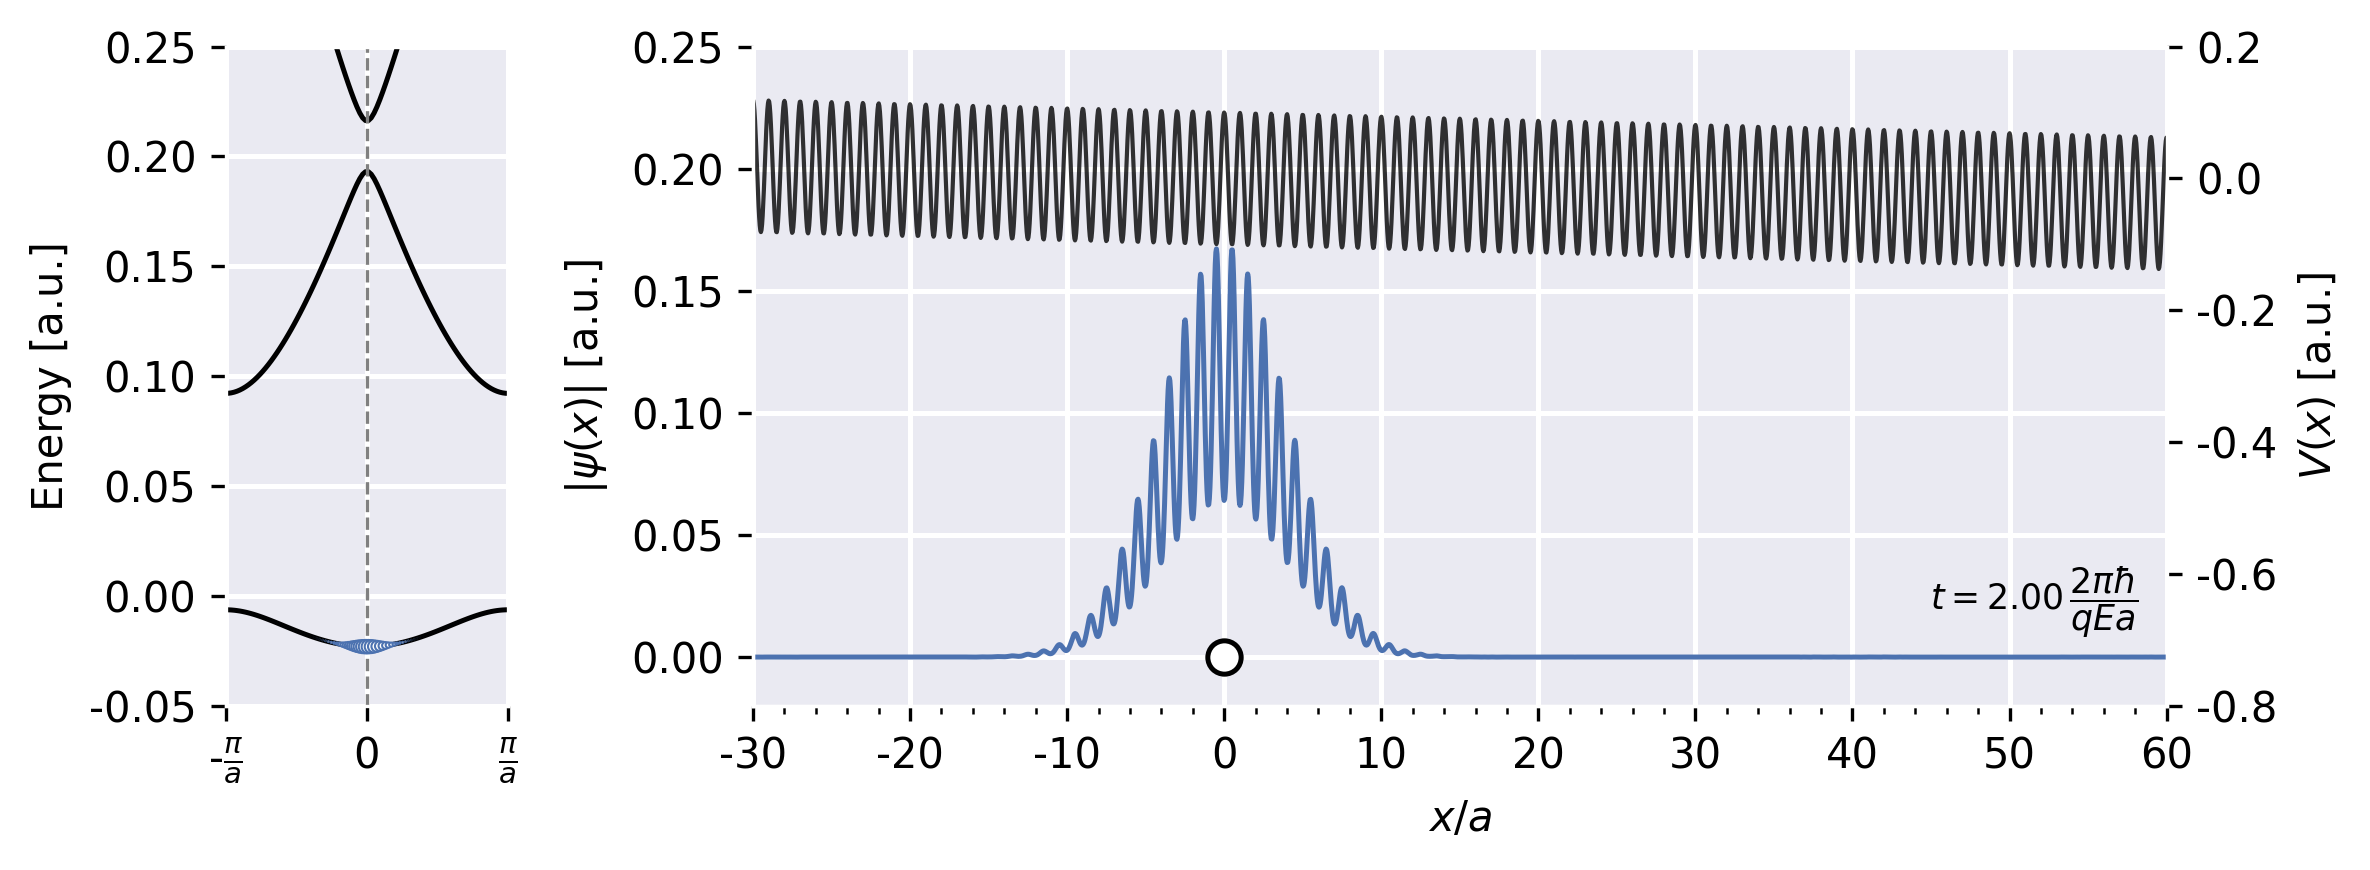

In [2]:
v0 = 0.05

n0       = 0
k0       = 0
sigma_k  = 0.04
ngx      = 20
kwp, fk  = get_bloch_wavepacket_gaussian_envelop(k0, sigma_k=sigma_k, nk=100, Nsigma=10)

Nc       = 150
L        = Nc * a
Nx       = 3999
x        = np.linspace(-0.4*L, 0.6*L, Nx)
dx       = x[1] - x[0]
bloch_wp = construct_blochwp_cosx_pot(x, kwp, fk, a=a, v0=v0, nbnds=nbnds, ngx=20)

k_1d_bz = np.linspace(-0.5, 0.5, 100)
Enk     = []
phi_nk  = []

Gx = np.arange(ngx, dtype=int)
Gx[ngx // 2 + 1:] -= ngx

for k in k_1d_bz:
    e, c = epsilon_nk_cosx_pot(k, a=a, v0=v0, ngx=ngx, nbnds=nbnds, Ngmax=1)
    Enk.append(e)
    cg = c[n0]
    phi_nk.append(np.sum(cg[:,None]*np.exp(1j*b*(Gx+k)[:,None] * x[None,:]), axis=0))
Enk = np.asarray(Enk)
phi_nk = np.asarray(phi_nk)

qE     = 2*np.pi / 1E5
Vx     = 2* v0 *np.cos(b*x) - qE*x
dt     = 1
Tbloch = 2 * np.pi / (qE * a)
NSW    = 2 * int(Tbloch / dt)
PSI0   = SplitStepFourier(bloch_wp, Vx, x, dt, NSW, False)

X0  = np.sum((np.abs(PSI0)**2) * x[:, None], axis=0) / np.sum((np.abs(PSI0)**2), axis=0)
X0 /= a

kwht = []
for ii in range(NSW):
    kwht.append(
        np.sum(
            phi_nk.conj() * PSI0[:,ii][None,:],
            axis=1
        )
    )
kwht = np.array(np.abs(kwht))
kc   = k_1d_bz[np.argmax(np.abs(kwht), axis=1)]

mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(8.0, 3.0), dpi=300)

axes = fig.subplot_mosaic(
    [[0, 1]],
    empty_sentinel=None,
    height_ratios=[1],
    width_ratios=[1, 5],
)
axes_list = [axes[ii] for ii in range(2)]

for ax in axes_list:
    ax.set_facecolor('#EAEAF2')
    ax.grid(True, color='white', linewidth=1.2, linestyle='-')
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_color('white')

ax = axes_list[0]
ax.axvline(x=0, lw=0.8, ls='--', color='gray')

emin = Enk.min()

for ii in range(nbnds):
    ax.plot(k_1d_bz, Enk[:,ii], color='black', lw=1.2, zorder=1)

scat = ax.scatter(
    k_1d_bz, Enk[:,n0], s=np.abs(kwht[0]) / 3,
    lw=0.5, color=deep_blue, facecolor='white', zorder=2
)

ax.set_xlim(-0.5, 0.5)
ax.set_xticks([-0.5, 0, 0.5], [r'-$\frac{\pi}{a}$', '0',  r'$\frac{\pi}{a}$'])
ax.set_ylim(-0.05, 0.25)
ax.set_ylabel('Energy [a.u.]')

ax = axes_list[1]
axt = ax.twinx()

l0, = ax.plot(x / a, np.abs(PSI0[:,0]), lw=1.2, color=deep_blue)
l1, = ax.plot([X0[0]], [0], ls='none',
        marker='o', ms=8, mew=1.2, mfc='white', mec='black')

axt.plot(x / a, Vx, lw=1.0, label=r'$V(x)$', color='black', alpha=0.8)

ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))

time_stamp = ax.text(
    0.98, 0.10,
    r'$t={:6.2f}\,\dfrac{{2\pi\hbar}}{{qEa}}$'.format(0),
    ha='right', va='bottom',
    family='monospace',
    fontsize='small',
    transform=ax.transAxes,
)

ax.set_ylim(-0.02, 0.25)
axt.set_ylim(-0.80, 0.20)
ax.set_xlim(-30, 60)

ax.set_xlabel(r'$x / a$', labelpad=5)

ax.set_ylabel(r'$|\psi(x)|$ [a.u.]', labelpad=5)
ax.tick_params(axis='y')

axt.set_ylabel(r'$V(x)$ [a.u.]', labelpad=5)
axt.tick_params(axis='y')
axt.spines['right'].set_color('white')
axt.spines['left'].set_color('white')
axt.spines['top'].set_color('white')
axt.spines['bottom'].set_color('white')

plt.tight_layout()

def wfc_propagation(iframe):
    l0.set_ydata(np.abs(PSI0[:,iframe*10]))
    l1.set_xdata([X0[iframe*10]])

    scat.set_sizes(np.abs(kwht[iframe*10]) / 3)

    time_stamp.set_text(
        r'$t={:6.2f}\,\dfrac{{2\pi\hbar}}{{qEa}}$'.format(iframe * 10 * dt / Tbloch),
    )

    return l0, l1, scat, time_stamp,

ani = animation.FuncAnimation(
    fig,
    wfc_propagation,
    interval=40,
    blit=True,
    repeat=True,
    frames=NSW//10,
)
ani.save('../simulation/bch_osc_tdse_ssfm.mp4', writer='ffmpeg', dpi=300)
plt.show()

In [ ]:
v0 = 0.02

n0       = 0
k0       = 0
sigma_k  = 0.04
ngx      = 20
kwp, fk  = get_bloch_wavepacket_gaussian_envelop(k0, sigma_k=sigma_k, nk=100, Nsigma=10)

Nc       = 150
L        = Nc * a
Nx       = 3999
x        = np.linspace(-0.4*L, 0.6*L, Nx)
dx       = x[1] - x[0]
bloch_wp = construct_blochwp_cosx_pot(x, kwp, fk, a=a, v0=v0, nbnds=nbnds, ngx=20)

k_1d_bz = np.linspace(-0.5, 0.5, 100)
Enk     = []
phi_nk  = []

Gx = np.arange(ngx, dtype=int)
Gx[ngx // 2 + 1:] -= ngx

for k in k_1d_bz:
    e, c = epsilon_nk_cosx_pot(k, a=a, v0=v0, ngx=ngx, nbnds=nbnds, Ngmax=1)
    Enk.append(e)
    cg = c[n0]
    phi_nk.append(np.sum(cg[:,None]*np.exp(1j*b*(Gx+k)[:,None] * x[None,:]), axis=0))
Enk = np.asarray(Enk)
phi_nk = np.asarray(phi_nk)

qE     = 2*np.pi / 1E5
Vx     = 2* v0 *np.cos(b*x) - qE*x
dt     = 1
Tbloch = 2 * np.pi / (qE * a)
NSW    = 2 * int(Tbloch / dt)
PSI0   = SplitStepFourier(bloch_wp, Vx, x, dt, NSW, False)

X0  = np.sum((np.abs(PSI0)**2) * x[:, None], axis=0) / np.sum((np.abs(PSI0)**2), axis=0)
X0 /= a

kwht = []
for ii in range(NSW):
    kwht.append(
        np.sum(
            phi_nk.conj() * PSI0[:,ii][None,:],
            axis=1
        )
    )
kwht = np.array(np.abs(kwht))
kc   = k_1d_bz[np.argmax(np.abs(kwht), axis=1)]

mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(8.0, 3.0), dpi=300)

axes = fig.subplot_mosaic(
    [[0, 1]],
    empty_sentinel=None,
    height_ratios=[1],
    width_ratios=[1, 5],
)
axes_list = [axes[ii] for ii in range(2)]

for ax in axes_list:
    ax.set_facecolor('#EAEAF2')
    ax.grid(True, color='white', linewidth=1.2, linestyle='-')
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_color('white')

ax = axes_list[0]
ax.axvline(x=0, lw=0.8, ls='--', color='gray')

emin = Enk.min()

for ii in range(nbnds):
    ax.plot(k_1d_bz, Enk[:,ii], color='black', lw=1.2, zorder=1)

scat = ax.scatter(
    k_1d_bz, Enk[:,n0], s=np.abs(kwht[0]) / 3,
    lw=0.5, color=deep_blue, facecolor='white', zorder=2
)

ax.set_xlim(-0.5, 0.5)
ax.set_xticks([-0.5, 0, 0.5], [r'-$\frac{\pi}{a}$', '0',  r'$\frac{\pi}{a}$'])
ax.set_ylim(-0.05, 0.25)
ax.set_ylabel('Energy [a.u.]')

ax = axes_list[1]
axt = ax.twinx()

l0, = ax.plot(x / a, np.abs(PSI0[:,0]), lw=1.2, color=deep_blue)
l1, = ax.plot([X0[0]], [0], ls='none',
        marker='o', ms=8, mew=1.2, mfc='white', mec='black')

axt.plot(x / a, Vx, lw=1.0, label=r'$V(x)$', color='black', alpha=0.8)

ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))

time_stamp = ax.text(
    0.98, 0.10,
    r'$t={:6.2f}\,\dfrac{{2\pi\hbar}}{{qEa}}$'.format(0),
    ha='right', va='bottom',
    family='monospace',
    fontsize='small',
    transform=ax.transAxes,
)

ax.set_ylim(-0.02, 0.25)
axt.set_ylim(-0.80, 0.20)
ax.set_xlim(-30, 60)

ax.set_xlabel(r'$x / a$', labelpad=5)

ax.set_ylabel(r'$|\psi(x)|$ [a.u.]', labelpad=5)
ax.tick_params(axis='y')

axt.set_ylabel(r'$V(x)$ [a.u.]', labelpad=5)
axt.tick_params(axis='y')
axt.spines['right'].set_color('white')
axt.spines['left'].set_color('white')
axt.spines['top'].set_color('white')
axt.spines['bottom'].set_color('white')

plt.tight_layout()

def wfc_propagation(iframe):
    l0.set_ydata(np.abs(PSI0[:,iframe*10]))
    l1.set_xdata([X0[iframe*10]])

    scat.set_sizes(np.abs(kwht[iframe*10]) / 3)

    time_stamp.set_text(
        r'$t={:6.2f}\,\dfrac{{2\pi\hbar}}{{qEa}}$'.format(iframe * 10 * dt / Tbloch),
    )

    return l0, l1, scat, time_stamp,

ani = animation.FuncAnimation(
    fig,
    wfc_propagation,
    interval=40,
    blit=True,
    repeat=True,
    frames=NSW//10,
)
ani.save('../simulation/bch_osc_tdse_ssfm_zener.mp4', writer='ffmpeg', dpi=300)
plt.show()